# Operator Based Clustering

In [2]:
from lxml import etree

def depth(node):
    d = 0
    while node is not None:
        d += 1
        node = node.getparent()
    return d

def helper(fname):
    xml=etree.parse(fname)
    root=xml.getroot()
    ast=[]
    ast.append({'index':0,'type':'SELECT','depth':0,'parent':-1})
    curr=0
    for child in root.iter("{http://schemas.microsoft.com/sqlserver/2004/07/showplan}RelOp"):
        # print(depth(child),child.attrib['PhysicalOp'])
        parent=-1
        if(depth(child)>ast[curr]['depth']):
            parent=curr
        else:
            i=curr
            while(ast[i]['depth']>=depth(child)):
                i-=1
            parent=i
        curr+=1
        data={
            'index':curr,
            'type':child.attrib['PhysicalOp'],
            'depth':depth(child),
            'parent':parent
        }
        ast.append(data)
    return ast

def find_child(arr,index):
    temp=[]
    for i in range(len(arr)):
        if arr[i]['parent']==index:
            temp.append(i)
    return temp
        
        
def func(arr,index):
    lst=find_child(arr,index)
    temp={'type':arr[index]['type'],'children':[]}
    for i in lst:
        val = func(arr, i)
        if len(val['children'])==0:
            temp['children'].append({'type':val['type']})
        else:
            temp['children'].append(val)
    return temp

In [5]:
q_list2=[1, 3, 4, 6, 10, 11, 12, 14, 16, 17, 22, 24, 25, 26, 27, 28, 30, 31, 33, 39, 45, 46]
import json
for i in range(len(q_list2)):
    fname=r"G:\dbquery-optimizer\tpcds\Execution_Plans\query_2\query_two_"+str(q_list2[i]+1)+".xml"
    lookup=helper(fname)
    tree=[func(lookup,0)]
    with open(r"G:\dbquery-optimizer\tpcds\notebooks\ast\query_two_"+str(q_list2[i]+1)+".json",'w') as file:
        json.dump(tree,file)

In [6]:
import subprocess

main=r"G:\dbquery-optimizer\tree2vec\main.py"

for i in range(len(q_list2)):
    inp=r"G:\dbquery-optimizer\tpcds\notebooks\ast\query_two_"+str(q_list2[i]+1)+".json"
    out=r"G:\dbquery-optimizer\tpcds\notebooks\vectors\query_two_"+str(q_list2[i]+1)+".json"
    try:
        p=subprocess.Popen(['python',main,'-i',inp,'-o',out],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stderr=p.communicate()[0]
        if(stderr):
            print(stderr)
    except:
        print("Error")


In [16]:
features=[]
exclude=[ 'chars_length_avg','chars_length_max',]
for i in range(len(q_list2)):
    with open(r"G:\dbquery-optimizer\tpcds\notebooks\vectors\query_two_"+str(q_list2[i]+1)+".json",'r') as file:
        doc=json.load(file)
        for key in doc.keys():
            if(key not in features and key not in exclude ):
                features.append(key)

# features

feature_val=[]
for i in range(len(q_list2)):
    with open(r"G:\dbquery-optimizer\tpcds\notebooks\vectors\query_two_"+str(q_list2[i]+1)+".json",'r') as file:
        doc=json.load(file)
        row=[]
        for key in features:
            if(key in doc.keys()):
                row.append(doc[key])
            else:row.append(0)
        feature_val.append(row)
    
len(feature_val[0])

142

In [19]:
for i in range(len(q_list2)):
    fname=r"G:\dbquery-optimizer\tpcds\Execution_Plans\query_2\query_two_"+str(q_list2[i]+1)+".xml"
    xml=etree.parse(fname)
    root=xml.getroot()
    nodes=0
    merge_join=0
    nested_loops=0
    hash_match=0
    sort=0
    ci_scan=0
    ci_seek=0
    parallelism=0
    compute_scalar=0
    filter=0
    aggr=0
    for child in root.iter("{http://schemas.microsoft.com/sqlserver/2004/07/showplan}RelOp"):
        op=child.attrib['PhysicalOp']
        if(op=='Stream Aggregate'):aggr+=1
        elif (op=='Hash Match'):hash_match+=1
        elif (op=='Filter'):filter+=1
        elif (op=='Clustered Index Scan'):ci_scan+=1
        elif (op=='Clustered Index Seek'):ci_seek+=1
        elif (op=='Parallelism'):parallelism+=1
        elif (op=='Compute Scalar'):compute_scalar+=1
        elif(op=='Merge Join'):merge_join+=1
        elif(op=='Nested Loops'):nested_loops+=1
        elif(op=='Sort'):sort+=1
        nodes+=1
    row=[1,aggr,parallelism,compute_scalar,hash_match,merge_join,nested_loops,sort,filter,ci_scan,ci_seek]
    row=[i/nodes for i in row]
    row.append(nodes)
    for j in row:
        feature_val[i].append(j)



In [21]:
import numpy as np
feature_val=np.array(feature_val)
feature_val.shape

(22, 154)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  


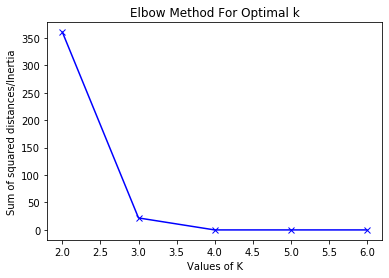

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.


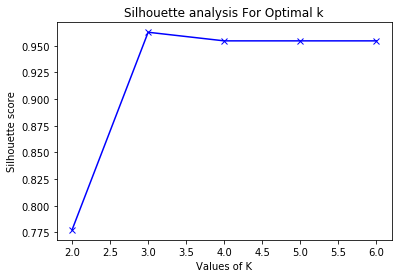

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
clusters= [i for i in range(2,7)]
Sum_of_squared_distances = []
for num_clusters in clusters :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(feature_val)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(clusters,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()
silhouette_avg = []
for num_clusters in clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(feature_val)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(feature_val, cluster_labels))
plt.plot(clusters,silhouette_avg,'bx-')
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [25]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(feature_val)
# kmeans.cluster_centers_
clusters=[{0:[],1:[],2:[]}]
for i in range(len(kmeans.labels_)):
    clusters[0][kmeans.labels_[i]].append(q_list2[i]+1)

clusters
# kmeans.cluster_centers_
# kmeans.labels_

[{0: [2, 4, 5, 12, 13, 15, 26, 28, 29, 34, 47],
  1: [7, 11, 17, 18, 23, 25, 40, 46],
  2: [27, 31, 32]}]

In [27]:
sums=[9999 for i in range(3)]
plans=[-1 for i in range(3)]
for i in range(len(q_list2)):
    sum=0
    for j in range(len(feature_val[i])):
        sum+=(kmeans.cluster_centers_[kmeans.labels_[i]][j]-feature_val[i][j])**2
    # print(sum,kmeans.labels_[i],end=" ")
    if(sums[kmeans.labels_[i]]>=sum):
        sums[kmeans.labels_[i]]=sum
        plans[kmeans.labels_[i]]=q_list2[i]+1
    # print()
plans

[47, 46, 32]

# Join-order Based Clustering

In [28]:
from lxml import etree

def depth(node):
    d = 0
    while node is not None:
        d += 1
        node = node.getparent()
    return d

def util(fname):
    xml=etree.parse(fname)
    root=xml.getroot()
    jot=[]
    jot.append({'index':0,'type':'root','depth':0,'parent':-1})
    curr=0
    joins=['Nested Loops','Merge Join','Hash Match']
    for child in root.iter("{http://schemas.microsoft.com/sqlserver/2004/07/showplan}RelOp"):  
        op=child.attrib['PhysicalOp']
        if(op in joins):
            # print(depth(child),child.attrib['PhysicalOp'])
            parent=-1
            if(depth(child)>jot[curr]['depth']):
                parent=curr
            else:
                i=curr
                while(jot[i]['depth']>=depth(child)):
                    i-=1
                parent=i
            curr+=1
            data={
                'index':curr,
                'type':child.attrib['PhysicalOp'],
                'depth':depth(child),
                'parent':parent
            }
            jot.append(data)
    return jot

def find_child(arr,index):
    temp=[]
    for i in range(len(arr)):
        if arr[i]['parent']==index:
            temp.append(i)
    return temp
        
        
def func(arr,index):
    lst=find_child(arr,index)
    temp={'type':arr[index]['type'],'children':[]}
    for i in lst:
        val = func(arr, i)
        if len(val['children'])==0:
            temp['children'].append({'type':val['type']})
        else:
            temp['children'].append(val)
    return temp

In [31]:
q_list2=[1, 3, 4, 6, 10, 11, 12, 14, 16, 17, 22, 24, 25, 26, 27, 28, 30, 31, 33, 39, 45, 46]

import json
for i in range(len(q_list2)):
    fname=r"G:\dbquery-optimizer\tpcds\Execution_Plans\query_2\query_two_"+str(q_list2[i]+1)+".xml"
    lookup=util(fname)
    tree=[func(lookup,1)]
    with open(r"G:\dbquery-optimizer\tpcds\notebooks\jot\query_two_"+str(q_list2[i]+1)+".json",'w') as file:
        json.dump(tree,file)

lookup

[{'index': 0, 'type': 'root', 'depth': 0, 'parent': -1},
 {'index': 1, 'type': 'Nested Loops', 'depth': 19, 'parent': 0},
 {'index': 2, 'type': 'Nested Loops', 'depth': 21, 'parent': 1}]

In [32]:
import subprocess

main=r"G:\dbquery-optimizer\tree2vec\main.py"

for i in range(len(q_list2)):
    inp=r"G:\dbquery-optimizer\tpcds\notebooks\jot\query_two_"+str(q_list2[i]+1)+".json"
    out=r"G:\dbquery-optimizer\tpcds\notebooks\jot-vectors\query_two_"+str(q_list2[i]+1)+".json"
    try:
        p=subprocess.Popen(['python',main,'-i',inp,'-o',out],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stderr=p.communicate()[0]
        if(stderr):
            print(stderr)
    except:
        print("Error")


In [35]:
jot_features=[]
# count=0
exclude=[ 'chars_length_avg','chars_length_max',]
for i in range(len(q_list2)):
    with open(r"G:\dbquery-optimizer\tpcds\notebooks\jot-vectors\query_two_"+str(q_list2[i]+1)+".json",'r') as file:
        doc=json.load(file)
        for key in doc.keys():
            # count+=1
            if(key not in jot_features and key not in exclude ):
                jot_features.append(key)

print(len(jot_features))

jot_vals=[]
for i in range(len(q_list2)):
    with open(r"G:\dbquery-optimizer\tpcds\notebooks\jot-vectors\query_two_"+str(q_list2[i]+1)+".json",'r') as file:
        doc=json.load(file)
        row=[]
        for key in jot_features:
            if(key in doc.keys()):
                row.append(doc[key])
            else:row.append(0)
        jot_vals.append(row)


7


In [ ]:
import numpy as np
jot_vals=np.array(jot_vals)
jot_vals

array([[ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.],
       [ 8., 18., 36.,  8.,  8.]])

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  


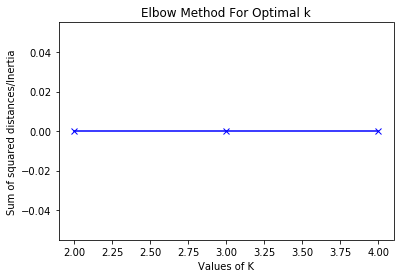

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
clusters= [i for i in range(2,5)]
Sum_of_squared_distances = []
for num_clusters in clusters :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(jot_vals)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(clusters,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()
silhouette_avg = []
for num_clusters in clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(jot_vals)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(jot_vals, cluster_labels))
plt.plot(clusters,silhouette_avg,'bx-')
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(jot_vals)
kmeans.cluster_centers_
clusters=[{0:[],1:[],2:[]}]
for i in range(len(kmeans.labels_)):
    clusters[0][kmeans.labels_[i]].append(q_list2[i]+1)

clusters

[{0: [2, 13, 14, 18, 22, 24, 26, 28, 30, 40, 44, 49],
  1: [5, 6, 9, 29, 33, 37, 41, 50],
  2: [15, 23, 35, 38, 42, 47]}]

In [ ]:
sums=[9999 for i in range(3)]
plans=[-1 for i in range(3)]
for i in range(len(q_list2)):
    sum=0
    for j in range(len(jot_vals[i])):
        sum+=(kmeans.cluster_centers_[kmeans.labels_[i]][j]-jot_vals[i][j])**2
    print(sum,kmeans.labels_[i],end=" ")
    if(sums[kmeans.labels_[i]]>=sum):
        sums[kmeans.labels_[i]]=sum
        plans[kmeans.labels_[i]]=q_list2[i]+1
    print()
plans

0.0 0 
0.0 1 
0.0 1 
0.0 1 
0.0 0 
0.0 0 
0.0 2 
0.0 0 
0.0 0 
0.0 2 
0.0 0 
0.0 0 
0.0 0 
0.0 1 
0.0 0 
0.0 1 
0.0 2 
0.0 1 
0.0 2 
0.0 0 
0.0 1 
0.0 2 
0.0 0 
0.0 2 
0.0 0 
0.0 1 


[49, 50, 47]

In [ ]:
kmeans.cluster_centers_

array([[4. , 4. , 1. , 2. , 1.5],
       [4. , 6. , 4. , 4. , 4. ],
       [4. , 5. , 2. , 3. , 3. ]])